In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from afm.visco import get_r, mdft
from afm.data_io import ibw2df, get_files, get_folders
from afm.math_funcs import sma, downsampu2v
from scipy.optimize import minimize, curve_fit
from scipy.signal.signaltools import correlate
import os

In [2]:
def offset_polynom(x, y_offset, x_offset, slope):
    # model of an offset polynomial with power 2 (3/2 doesn't seem to work!)
    poly = 2
    d = x - x_offset
    return slope * (abs(d) - d) ** poly + y_offset

def fit_contact(df, k):
    # fit QUADRATIC f-z model to data and return contact location and index
    # format f-d dataframe values and cut to maximum
    f = df.Defl.values * k
    i = np.argmax(f)
    z_tip = (df.Defl - df.ZSnsr).values[:i]
    f = f[:i]

    # normalize f-d values
    x = z_tip - z_tip[0]
    x /= max(abs(x))
    y = f - f[0]
    y /= max(abs(f))

    # fit to the offset polynomial model
    X, _ = curve_fit(offset_polynom, x, y)
    y_offset, x_offset, slope = X

    # reverse the normalization and get index
    z_offset = x_offset * max(abs(z_tip - z_tip[0])) + z_tip[0]
    j = np.argmin((z_tip - z_offset) ** 2)
    return {'z contact': z_offset, 'contact index': j, 'max index': i}

def load_all_files_from_(dir_name):
    files = {}
    for i, file in enumerate(get_files(dir_name)):
        files.update({file: ibw2df(file)})
    return files

def fd_format_(df, k):
    points = fit_contact(df, k)
    f = df.Defl.values * k
    h = (df.ZSnsr - df.Defl).values
    z_tip = (df.Defl - df.ZSnsr).values
    
    f = f[points['contact index']: points['max index']]
    h = h[points['contact index']: points['max index']]
    d = (z_tip - points['z contact'])[points['contact index']: points['max index']]
    
    return pd.DataFrame({'f': f - f[0], 'h': h - h[0], 'd': d})
    
def format_all_fds_to_repulsive_from_(fd_dict, k):
    formatted_fds = {}
    for filename, df in fd_dict.items():
        formatted_fds.update({filename: fd_format_(df, k)})
    return formatted_fds

def hertzian(h, E):
    return a * E * h ** b

def hertz_fit(df):
    h = abs(df.h.values)
    f = abs(df.f.values)
    E, _ = curve_fit(hertzian, h, f)
    return E

def get_win_size(size, pct):
    length = int(size * pct)
    if length == 0:
        return 1
    else:
        return length

def process_fds_(fd_list):
    processed = []
    for df in fd_list:
        win_size = get_win_size(df.f.size, pct_smooth)
        f = sma(df.f.values, win_size)
        h = sma(df.h.values, win_size)
        f = abs(f - f[0])
        h = abs(h - h[0])
        processed.append(pd.DataFrame({'f': f, 'h': h}))
    return processed

def get_fourier_magnitude_at_freq(f, sampling_freq, guess_freq):
    # take transform
    w = np.linspace(-1, 1, f.size) * sampling_freq / 2
    f_w = mdft(f, 1.0)
    region = (w > guess_freq / 10) * (w < guess_freq * 10)
    i = np.abs(f_w[region]).argmax()
    return f_w[region][i]

In [226]:
r = 2e-6
k = 0.2531
a = 16 * np.sqrt(r) / 3
b = 1.5
freq = 50e3

In [4]:
path = r'/home/mmccraw/Desktop/gwu/data/221115_gelma/soft'

In [5]:
ULTRASLOW = load_all_files_from_(path + '/ultraslow')

In [6]:
SLOW = load_all_files_from_(path + '/slow')

In [7]:
FAST = load_all_files_from_(path + '/fast')

In [8]:
# formatting
fds = {}
for name, fd_dict in zip(['0.1um/s', '1um/s', '10um/s'], [ULTRASLOW, SLOW, FAST]):
    fds.update({name: format_all_fds_to_repulsive_from_(fd_dict, k)})
    print('done with '+name)

done with 0.1um/s
done with 1um/s
done with 10um/s


done with 0.1um/s
done with 1um/s
done with 10um/s


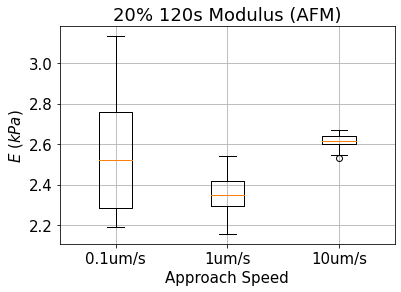

In [25]:
# fitting to elastic model
hertzian_moduli = {}
for speed, fd_dicts in fds.items():
    hertzian_moduli.update({speed: [hertz_fit(df)[0]/1e3 for df in fd_dicts.values()]})
    print('done with '+speed)
    
fig, ax = plt.subplots()
ax.boxplot(hertzian_moduli.values())
ax.set_xticklabels(hertzian_moduli.keys())
plt.grid()
plt.title('20% 120s Modulus (AFM)')
plt.xlabel('Approach Speed')
plt.ylabel('$E$ ($kPa$)')
plt.savefig('gelma 2022 11 15/gelma_youngs_modulus.svg', dpi=600)
plt.show()

In [17]:
# fit fd viscoelastic models
def sls_time(h, t, Ge, G, U):
    dt = t[1] - t[0]
    H = a * h ** b
    return (Ge + G) * H - G ** 2 / U * np.convolve(np.exp(-t * G / U), H, 'full')[: t.size] * dt
def obj(X, f, h, t):
    Ge, G, U = X
    f_fit = sls_time(h, t, Ge, G, U)
    return np.sum((f_fit - f) ** 2)

x0 = [4.22612574e+03, 2.61073893e+04, 2.84948726e+00]  # taken from z domain fitting below
bounds = ((0, 4226.162988795047), (0, np.inf), (0, np.inf))  # taken from z domain fitting below
desired_size = 2500  # for speed

time_fits = {}
for speed in fds.keys():
    fit_vals = []
    for df in fds[speed].values():
        f = df.f.values
        h = df.h.values
        t = np.linspace(0, f.size / freq, f.size)
        
        if f.size > desired_size:
            f = downsampu2v(f, np.ones(desired_size))
            h = downsampu2v(h, np.ones(desired_size))
            t = downsampu2v(t, np.ones(desired_size))
            
        # minimize the objective function
        res = minimize(obj,  # tell the minimizer what function to minimize
                       x0=x0,  # give an initial guess
                       args=(f, h, t),  # give the remaining arguments for obj
                       bounds=bounds,
                       method='Nelder-Mead',  # i like this algorithm the most
                       options={'maxiter': 1e3, # max number of iterations
                                'maxfev': 1e3,  # max number of obj function evals
                                'xatol': 1e-10,  # required precision
                                'fatol': 1e-10})
        fit_vals.append(res.x)
        print(res.x)
    print('done with '+speed)
    time_fits.update({speed: fit_vals})

/tmp/ipykernel_100814/3307575299.py:4: RuntimeWarning: invalid value encountered in power
  H = a * h ** b


[4.22612574e+03 2.61073893e+04 2.84948726e+00]
[4.22612574e+03 2.61073893e+04 2.84948726e+00]
[4.22612574e+03 2.61073893e+04 2.84948726e+00]
[4.22612574e+03 2.61073893e+04 2.84948726e+00]
[4.22612574e+03 2.61073893e+04 2.84948726e+00]
[4.22612574e+03 2.61073893e+04 2.84948726e+00]
[4.22612574e+03 2.61073893e+04 2.84948726e+00]
[4.22612574e+03 2.61073893e+04 2.84948726e+00]
[4.22612574e+03 2.61073893e+04 2.84948726e+00]


/tmp/ipykernel_100814/3307575299.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  return (Ge + G) * H - G ** 2 / U * np.convolve(np.exp(-t * G / U), H, 'full')[: t.size] * dt
/tmp/ipykernel_100814/3307575299.py:5: RuntimeWarning: divide by zero encountered in true_divide
  return (Ge + G) * H - G ** 2 / U * np.convolve(np.exp(-t * G / U), H, 'full')[: t.size] * dt
/tmp/ipykernel_100814/3307575299.py:5: RuntimeWarning: invalid value encountered in true_divide
  return (Ge + G) * H - G ** 2 / U * np.convolve(np.exp(-t * G / U), H, 'full')[: t.size] * dt


[4.22616299e+03 3.41232417e+03 4.95957584e-03]
[4.22612574e+03 2.61073893e+04 2.84948726e+00]
[4.22612574e+03 2.61073893e+04 2.84948726e+00]
done with 0.1um/s
[4.22612574e+03 2.61073893e+04 2.84948726e+00]
[4.22612574e+03 2.61073893e+04 2.84948726e+00]
[4.22612574e+03 2.61073893e+04 2.84948726e+00]
[4.22616299e+03 5.25881817e+02 1.42282533e-03]
[4.22612574e+03 2.61073893e+04 2.84948726e+00]
[4.22612574e+03 2.61073893e+04 2.84948726e+00]
[4.22612574e+03 2.61073893e+04 2.84948726e+00]
[4.22616210e+03 5.00828988e+02 1.34493942e-03]
[4.22614452e+03 4.82661850e+02 1.26035018e-03]
[4.22612574e+03 2.61073893e+04 2.84948726e+00]
[4.22612574e+03 2.61073893e+04 2.84948726e+00]
[4.22612574e+03 2.61073893e+04 2.84948726e+00]
[4.22612574e+03 2.61073893e+04 2.84948726e+00]
[4.22612574e+03 2.61073893e+04 2.84948726e+00]
[4.22612574e+03 2.61073893e+04 2.84948726e+00]
[4.22612574e+03 2.61073893e+04 2.84948726e+00]
[4.22612574e+03 2.61073893e+04 2.84948726e+00]
[4.22616299e+03 5.93427565e+02 1.52760184e

/tmp/ipykernel_100814/1966197588.py:12: RuntimeWarning: invalid value encountered in power
  ax.plot(h * 1e6, a * h ** b * np.mean(hertzian_moduli[speed]) * 1e3 * 1e9, color='r',
/tmp/ipykernel_100814/1966197588.py:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


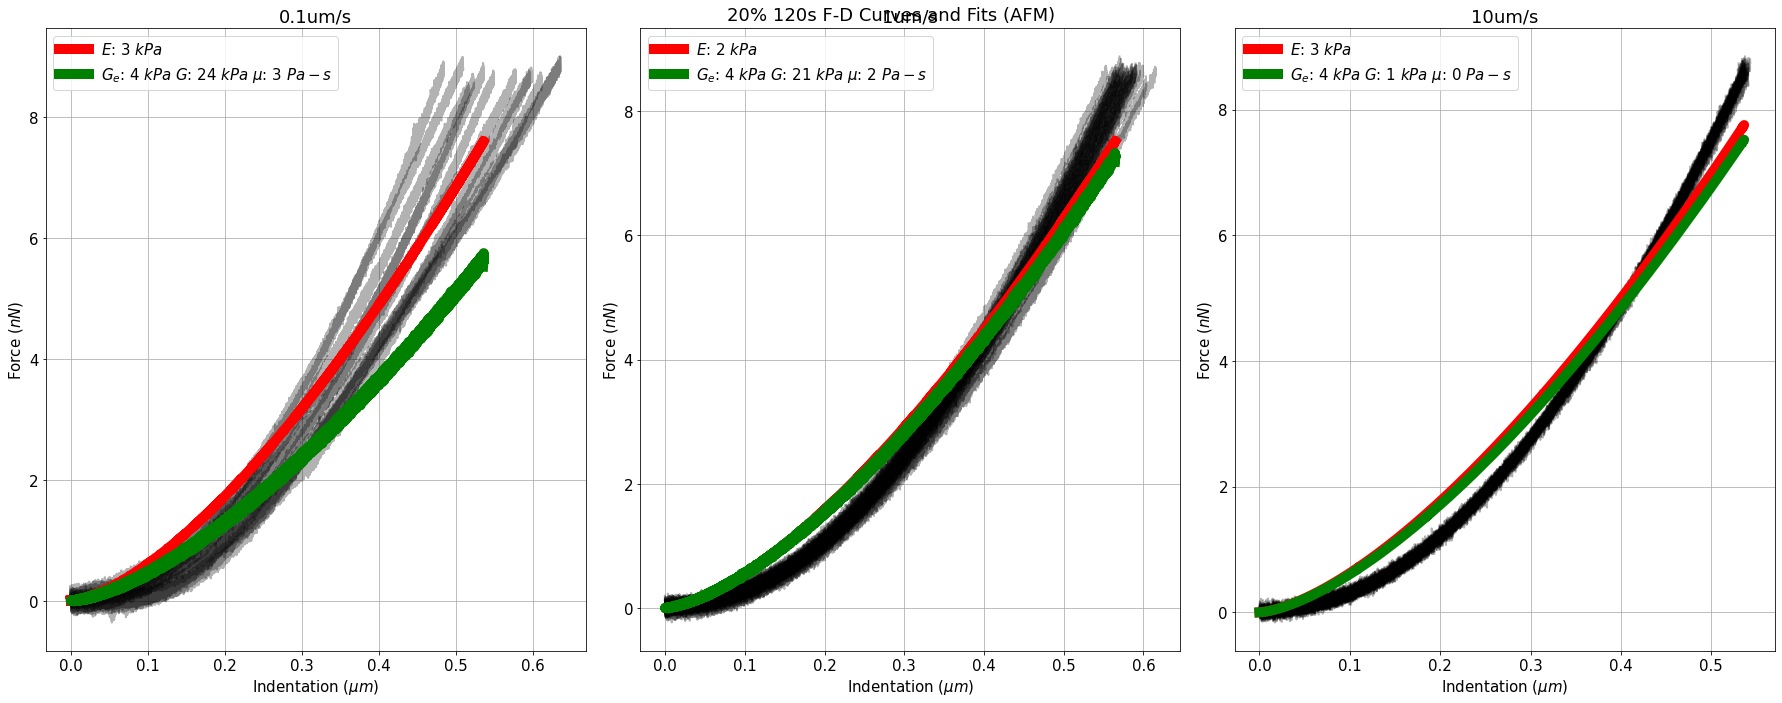

In [183]:
fig, axs = plt.subplots(1, 3, figsize=(25, 10))

for ax, (speed, fd_list) in zip(axs, fds.items()):
    Ge, G, U = np.mean(time_fits[speed], axis=0)
    for df in [_ for _ in fd_list.values()][:]:
        f = df.f.values
        h = df.h.values
        t = np.linspace(0, f.size / freq, f.size)
        ax.plot(h * 1e6, f * 1e9, linewidth=2, color='k', alpha=0.3)

    ax.set_title(speed)
    ax.plot(h * 1e6, a * h ** b * np.mean(hertzian_moduli[speed]) * 1e3 * 1e9, color='r', 
            linewidth=10, label='$E$: {:.0f} $kPa$'.format(np.mean(hertzian_moduli[speed])))
    Ge, G, U = np.mean(time_fits[speed], axis=0)
    ax.plot(h * 1e6, sls_time(abs(h), t, Ge, G, U) * 1e9, color='g', linewidth=10, 
            label='$G_e$: {:.0f} $kPa$ $G$: {:.0f} $kPa$ $\mu$: {:.0f} $Pa-s$'.format(
                Ge/1e3, G/1e3, U))
    ax.legend()
    ax.grid()
    ax.set_xlabel('Indentation ($\mu m$)')
    ax.set_ylabel('Force ($nN$)')
plt.tight_layout()
plt.suptitle('20% 120s F-D Curves and Fits (AFM)')
plt.savefig('gelma 2022 11 15/gelma_fd_curves_and_fits.svg', dpi=600)
plt.show()

In [18]:
# viscoelastic moduli
viscoelastic_moduli = {}
pct_smooth = 0.1

for speed, fd_dicts in fds.items():
    fd_list = process_fds_(fd_dicts.values())
    r = max(max(get_r(df.f.values), get_r(df.h.values ** b)) for df in fd_list) * 1.1
    N = min(df.f.size for df in fd_list)
    fz = np.array([mdft(df.f.values, r, N) for df in fd_list])
    hz = np.array([mdft(df.h.values ** b, r, N) for df in fd_list])
    w = np.linspace(-1, 1, N) * freq / 2
    q_mean = np.mean(fz, axis=0) / np.mean(hz, axis=0) / a
    q = [f / h / a for f, h in zip(fz, hz)]
    viscoelastic_moduli.update({speed: {'f': fz, 'h': hz, 'q_mean': q_mean, 'q': q, 'w': w}})

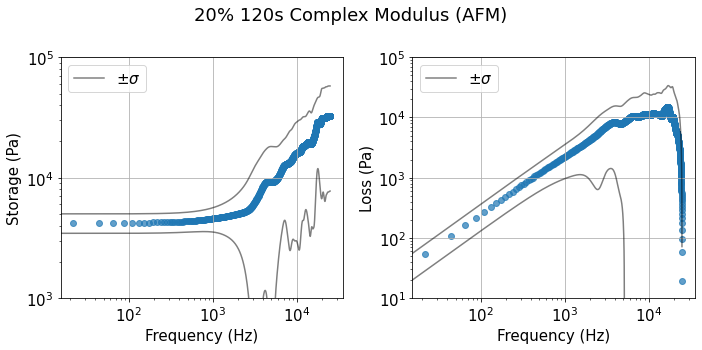

In [239]:
speed = '10um/s'
w = viscoelastic_moduli[speed]['w']
q_mean = viscoelastic_moduli[speed]['q_mean']
qs = [f / h / a for f, h in 
      zip(viscoelastic_moduli[speed]['f'], viscoelastic_moduli[speed]['h'])]
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
def re(arr):
    return np.real(arr)
def im(arr):
    return np.imag(arr)
for ax, func, lims, ylabel in zip(axs, [re, im], 
                                  (((1e3, 1e5)), (1e1, 1e5)), 
                                  ('Storage (Pa)', 'Loss (Pa)')):
    ax.scatter(w, func(q_mean), alpha=0.7)
    ax.plot(w, func(q_mean) + np.std(func(qs), axis=0), color='k', alpha=0.5, label='$\pm\sigma$')
    ax.plot(w, func(q_mean) - np.std(func(qs), axis=0), color='k', alpha=0.5)
    ax.legend(loc='upper left')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(lims[0], lims[1])
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Frequency (Hz)')
    ax.grid()
plt.suptitle('20% 120s Complex Modulus (AFM)')
plt.tight_layout()
plt.savefig('gelma 2022 11 15/gelma_complex_modulus_std.svg', dpi=600)
plt.show()

/home/mmccraw/anaconda3/envs/afm/lib/python3.10/site-packages/scipy/optimize/_constraints.py:331: ComplexWarning: Casting complex values to real discards the imaginary part
  ub = np.array([float(_arr_to_scalar(x)) if x is not None else np.inf
/tmp/ipykernel_100814/913861356.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return Ge + G - G / (1 + 1j * w * U / G)
/tmp/ipykernel_100814/913861356.py:3: RuntimeWarning: invalid value encountered in true_divide
  return Ge + G - G / (1 + 1j * w * U / G)


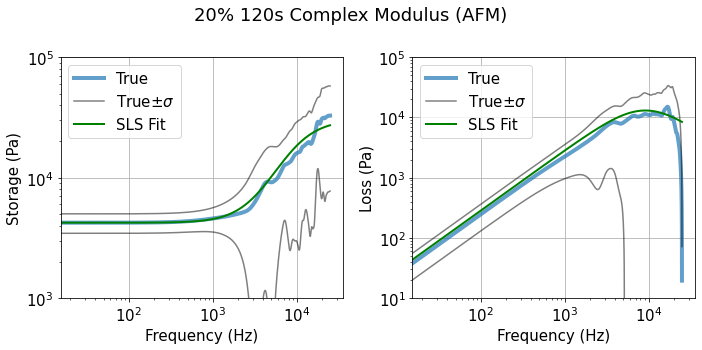

[4.22612574e+03 2.61073893e+04 2.84948726e+00]


In [204]:
# fit z models
def sls(w, Ge, G, U):
    return Ge + G - G / (1 + 1j * w * U / G)
def obj(X, Q_real, w):
    Ge, G, U = X
    Q_fit = sls(w, Ge, G, U)
    return np.sum(np.real(Q_fit - Q_real) ** 2 + np.imag(Q_fit - Q_real) ** 2)

# minimize the objective function
res = minimize(obj,  # tell the minimizer what function to minimize
               x0=[1, 1, 1],  # give an initial guess
               args=(q_mean, w),  # give the remaining arguments for obj
               bounds=((0, q_mean[((w - 0)**2).argmin()]), (0, np.inf), (0, np.inf)),
               method='Nelder-Mead',  # i like this algorithm the most
               options={'maxiter': 1e3, # max number of iterations
                        'maxfev': 1e3,  # max number of obj function evals
                        'xatol': 1e-10,  # required precision
                        'fatol': 1e-10})
Ge, G, U = res.x
visco_fits = res.x
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for ax, func, lims, ylabel in zip(axs, [re, im], 
                                  (((1e3, 1e5)), (1e1, 1e5)), 
                                  ('Storage (Pa)', 'Loss (Pa)')):
    ax.plot(w, func(q_mean), alpha=0.7, linewidth=4, label='True')
    ax.plot(w, func(q_mean) + np.std(func(qs), axis=0), color='k', alpha=0.5, label='True$\pm\sigma$')
    ax.plot(w, func(q_mean) - np.std(func(qs), axis=0), color='k', alpha=0.5)
    ax.plot(w, func(sls(w, Ge, G, U)), color='g', label='SLS Fit', linewidth=2)
    ax.legend(loc='upper left')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(lims[0], lims[1])
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Frequency (Hz)')
    ax.grid()
plt.suptitle('20% 120s Complex Modulus (AFM)')
plt.tight_layout()
plt.savefig('gelma 2022 11 15/gelma_complex_modulus_with_fits.svg', dpi=600)
plt.show()
print(res.x)

In [21]:
CREEP = load_all_files_from_(path + '/creep')
# doesn't look like a lot of creep

In [22]:
folders = np.array(get_folders(path + '/harmonic'))
freqs = [int(f.split('/')[-1].strip('hz')) for f in folders]
harmonics = {}
for order in np.argsort(freqs):
    data = []
    for filename in os.listdir(folders[order]):
        data.append(ibw2df(folders[order] + '/' + filename.decode('utf-8')))
    harmonics.update({freqs[order]: data})
    print(freqs[order])

1
10
20
30
40
50
100
200
500
1000


In [23]:
phases = []
freqs = []
phases_box = {}
for exc_freq in harmonics.keys():
    phase = []
    for df in harmonics[exc_freq]:
        points = fit_contact(df, k)
        f = df.Defl.values * k
        h = (df.ZSnsr - df.Defl).values
        z_tip = (df.Defl - df.ZSnsr).values

        # cut to contact
        f = f[points['contact index']:]
        h = h[points['contact index']:]
        z_tip = z_tip[points['contact index']:]
        f -= f[0]
        t = np.linspace(0, f.size / freq, f.size)
        win = (t > 1) * (t < 10)

        # cut to dwell period
        t = t[win]
        f = f[win]
        h = a * h[win] ** b
        w = np.linspace(-1, 1, f.size) * freq / 2

        # remove any background shift from h and f
        h_shift = h - np.polyval(np.polyfit(t, h, 4), t)
        f_shift = f - np.polyval(np.polyfit(t, f, 4), t)

        # get fourier magnitudes of f and h
        mf = get_fourier_magnitude_at_freq(f_shift, freq, exc_freq)
        mh = get_fourier_magnitude_at_freq(h_shift, freq, exc_freq)
        # get modulus and normalize
#         m = mh / mf
#         r = np.sqrt(abs(m * np.conjugate(m)))
#         phase.append(np.arccos(np.real(m) / r))
        p = (np.real(mf) * np.real(mh) + np.imag(mf) * np.imag(mh)) / (abs(mf) * abs(mh))
        phase.append(np.arccos(p) / np.pi)
        
        region = (w > exc_freq / 10) * (w < exc_freq * 10)
    
        freqs.append(exc_freq)
        phases.append(phase[-1])
    print(exc_freq)
    phases_box.update({exc_freq: phase})

1
10
20
30
40
50
100
200
500
1000


In [224]:
freq

1000

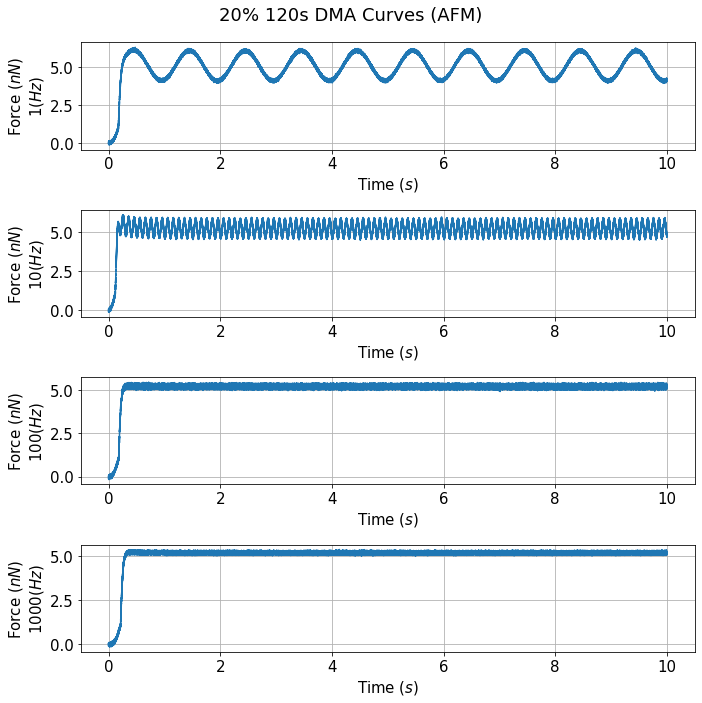

In [238]:
fig, axs = plt.subplots(4, 1, figsize=(10, 10))
for ax, freq_ in zip(axs, [1, 10, 100, 1000]):
    df = harmonics[freq_][0]
    points = fit_contact(df, k)
    f = df.Defl.values * k
    h = (df.ZSnsr - df.Defl).values
    z_tip = (df.Defl - df.ZSnsr).values

    # cut to contact
    f = f[points['contact index']:]
    h = h[points['contact index']:]
    z_tip = z_tip[points['contact index']:]
    f -= f[0]
    t = np.linspace(0, f.size / freq, f.size)
    
    ax.plot(t[t<10], f[t<10] * 1e9)
    ax.set_ylabel('Force ($nN$)\n'+str(freq_)+'$(Hz)$')
    ax.set_xlabel('Time ($s$)')
    ax.grid()
plt.suptitle('20% 120s DMA Curves (AFM)')
plt.tight_layout()
plt.savefig('gelma 2022 11 15/gelma_dma.svg', dpi=600)
plt.show()

In [213]:
E_fits = np.mean([np.mean(hertzian_moduli[speed]) for speed in fds.keys()])
G_fits = np.mean([np.mean(time_fits[speed], axis=0) for speed in fds.keys()], axis=1)
master_data = {'Hertzian fit (Pa)': [E_fits*1e3],
               'SLS time fit Ge (Pa)': [G_fits[0]],
               'SLS time fit G (Pa)': [G_fits[1]],
               'SLS time fit U (Pa s)': [G_fits[2]],
               'z transform frequency (Hz)': w,
               'G* z transform (Pa)': q_mean,
               'SLS z fit Ge (Pa)': [visco_fits[0]],
               'SLS z fit G (Pa)': [visco_fits[1]],
               'SLS z fit U (Pa s)': [visco_fits[2]],
               'dma frequency (Hz)': freqs,
               'dma loss angle pi normalized': phases}
pd.DataFrame.from_dict(master_data, orient='index').T.to_excel('gelma 2022 11 15/master_data.xlsx')

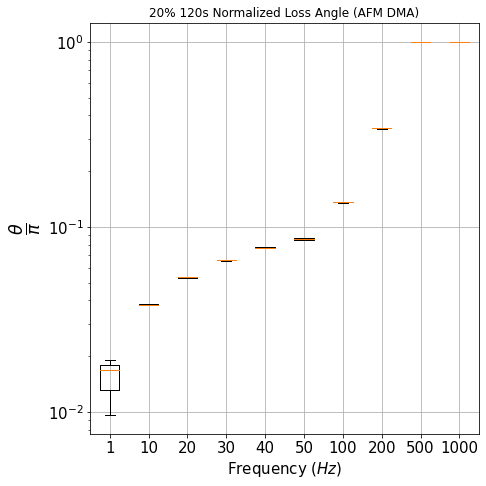

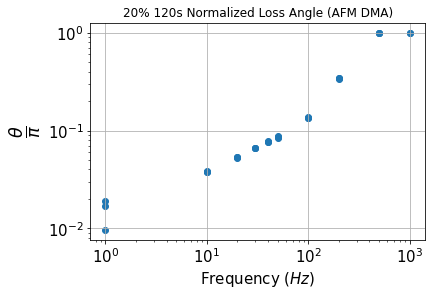

In [33]:
font = {'size'   : 15}
plt.rc('font', **font)
fig, ax = plt.subplots(1, figsize=(7, 7))
ax.boxplot(phases_box.values())
ax.set_xticklabels(phases_box.keys())
ax.set_yscale('log')
ax.set_xlabel('Frequency ($Hz$)')
plt.grid()
ax.set_ylabel(r'$\frac{\theta}{\pi}$', fontsize=25)
plt.title('20% 120s Normalized Loss Angle (AFM DMA)', fontsize=12)
plt.tight_layout()
plt.savefig('gelma 2022 11 15/gelma_loss_angle_boxplot.svg', dpi=600)
plt.show()
plt.scatter(freqs, phases)
plt.ylabel(r'$\frac{\theta}{\pi}$', fontsize=25)
plt.xscale('log')
plt.grid()
plt.title('20% 120s Normalized Loss Angle (AFM DMA)', fontsize=12)
plt.xlabel('Frequency ($Hz$)', fontsize=15)
plt.yscale('log')
plt.savefig('gelma 2022 11 15/gelma_loss_angle_scatter.svg', dpi=600)
plt.show()

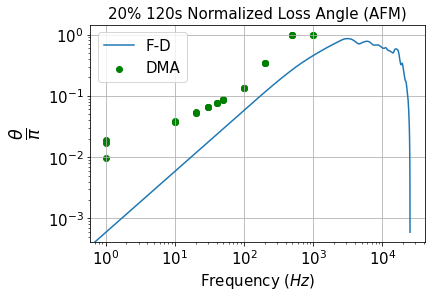

In [54]:
plt.plot(w, np.arctan(np.imag(q_mean) / np.real(q_mean)), label='F-D')
plt.scatter(freqs, phases, color='g', label='DMA')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.xlabel('Frequency ($Hz$)')
plt.ylabel(r'$\frac{\theta}{\pi}$', fontsize=25)
plt.title('20% 120s Normalized Loss Angle (AFM)', fontsize=15)
plt.savefig('gelma 2022 11 15/gelma_loss_angle_fd_and_dma.svg', dpi=600)
plt.show()

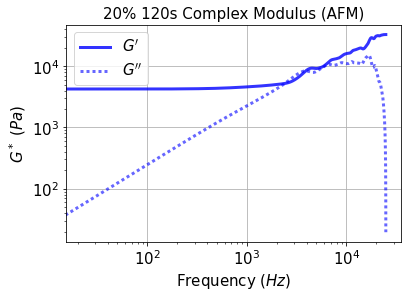

In [77]:
plt.plot(w, np.real(q_mean), color='b', alpha=0.8, linewidth=3, linestyle='-', label='$G\'$')
plt.plot(w, np.imag(q_mean), color='b', alpha=0.6, linewidth=3, linestyle=(0, (1, 1)), label='$G\'\'$')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.ylabel('$G^*$ ($Pa$)')
plt.xlabel('Frequency ($Hz$)')
plt.title('20% 120s Complex Modulus (AFM)', fontsize=15)
plt.savefig('gelma 2022 11 15/gelma_complex_modulus.svg', dpi=600)
plt.show()

In [240]:
# brachiation model fitting
